In [27]:
#2.1 Loading the MNIST dataset

import tensorflow_datasets as tfds 
import tensorflow as tf

(train_ds, test_ds), ds_info = tfds.load('mnist', split=['train', 'test'], as_supervised=True, with_info=True)
#tfds.show_examples(train_ds , ds_info)

# 2.2 Setting up the data pipeline

def data_pipeline(input, batch_size=64, prefetch_buffer_size=4):  
    # Map the dataset to extract images and labels
    input =input.map(lambda image, label: (image, label))
    # Reshape each image to a flat vector
    input = input.map(lambda image, label: (tf.reshape(image, (-1,)), label))   
    # Normalize(Scale) image values to be in the range [-1, 1]
    input = input.map(lambda image, label: ((tf.cast(image, tf.float32) / 128) - 1, label))     
    # One-hot encode the labels
    input = input.map(lambda image, label: (image, tf.one_hot(label, depth=10)))   
    # Shuffle the dataset and create batches of size 4
    input = input.shuffle(1024).batch(batch_size)
    # Prefetch the dataset to improve pipeline performance
    input = input.prefetch(prefetch_buffer_size)
    return input

# Save the datasets after applying the data pipeline
train_dataset = data_pipeline(train_ds)
test_dataset = data_pipeline(test_ds)

for elem in train_dataset.take(1):
    print(elem)
    
for elem in test_dataset.take(1):
    print(elem)

(<tf.Tensor: shape=(64, 784), dtype=float32, numpy=
array([[-1., -1., -1., ..., -1., -1., -1.],
       [-1., -1., -1., ..., -1., -1., -1.],
       [-1., -1., -1., ..., -1., -1., -1.],
       ...,
       [-1., -1., -1., ..., -1., -1., -1.],
       [-1., -1., -1., ..., -1., -1., -1.],
       [-1., -1., -1., ..., -1., -1., -1.]], dtype=float32)>, <tf.Tensor: shape=(64, 10), dtype=float32, numpy=
array([[0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 

2023-11-21 14:52:01.272385: W tensorflow/core/kernels/data/cache_dataset_ops.cc:858] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2023-11-21 14:52:01.313728: W tensorflow/core/kernels/data/cache_dataset_ops.cc:858] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


In [28]:
# 2.3 Building a deep neural network with TensorFlow
import tensorflow as tf
from tensorflow.keras import layers

class MLPModel(tf.keras.Model):
    def __init__(self, layer_sizes, output_size=10):
        super().__init__()
        self.mlp_layers = []  # create a list to store hidden layers

        # Create hidden layers with ReLU activation
        for layer_size in layer_sizes:
            new_layer = layers.Dense(units=layer_size, activation='relu')
            self.mlp_layers.append(new_layer)
        # Output layer with softmax activation for classification
        self.output_layer = layers.Dense(units=output_size, activation='softmax')

    def call(self, x):
        # Forward pass through hidden layers
        for mlp_layer in self.mlp_layers:
            x = mlp_layer(x)      
        # Forward pass through the output layer
        y = self.output_layer(x)
        return y


In [29]:
# 2.4 Training the network
"""
Define a training loop function which receives 
• The number of epochs
• The model object
• The training dataset
• The test dataset
• The loss function
• The optimizer
• Different arrays for the different values you want to track for visualization
"""

## hyperparameter 에 learning rate 넣은 버전 trainingmodel

import tensorflow as tf
import numpy as np

def train_model(num_epochs, model, train_dataset, test_dataset, loss_function, learning_rate, optimizer):
    optimizer.learning_rate.assign(learning_rate)  # Update the learning rate of the optimizer
    train_losses = []
    test_losses = []
    train_accuracies = []  # Track training accuracy
    test_accuracies = []   # Track testing accuracy

    for epoch in range(num_epochs):
        epoch_train_losses = []
        correct_train_predictions = 0  # Counter for correct training predictions
        total_train_samples = 0

        # Training phase
        for x_train, target_train in train_dataset:
            with tf.GradientTape() as tape:
                # Forward pass
                pred_train = model(x_train)
                # Calculate the training loss
                loss_train = loss_function(target_train, pred_train)
            
            # Calculate gradients
            gradients_train = tape.gradient(loss_train, model.trainable_variables)
            
            # Update weights using optimizer
            optimizer.apply_gradients(zip(gradients_train, model.trainable_variables))
            
            # Append the training loss to the list
            epoch_train_losses.append(loss_train.numpy())

            # Calculate training accuracy
            correct_train_predictions += np.sum(np.argmax(target_train, axis=1) == np.argmax(pred_train, axis=1))
            total_train_samples += len(x_train)

        train_accuracy = correct_train_predictions / total_train_samples
        train_accuracies.append(train_accuracy)

        # Testing phase
        epoch_test_losses = []
        correct_test_predictions = 0  # Counter for correct testing predictions
        total_test_samples = 0

        for x_test, target_test in test_dataset:
            # Forward pass
            pred_test = model(x_test)
            # Calculate the testing loss
            loss_test = loss_function(target_test, pred_test)
            epoch_test_losses.append(loss_test.numpy())

            # Calculate testing accuracy
            correct_test_predictions += np.sum(np.argmax(target_test, axis=1) == np.argmax(pred_test, axis=1))
            total_test_samples += len(x_test)

        test_accuracy = correct_test_predictions / total_test_samples
        test_accuracies.append(test_accuracy)

        # Print the mean training and testing loss and accuracy for the epoch
        mean_train_loss = np.mean(epoch_train_losses)
        mean_test_loss = np.mean(epoch_test_losses)
        print(f"Epoch {epoch + 1},\n Train Loss: {mean_train_loss}, Train Accuracy: {train_accuracy},\n Test Loss: {mean_test_loss}, Test Accuracy: {test_accuracy}")

        # Append losses to the lists for visualization
        train_losses.append(mean_train_loss)
        test_losses.append(mean_test_loss)

    return train_losses, test_losses, train_accuracies, test_accuracies

In [30]:
# learning rate 없는 visualisation

import matplotlib.pyplot as plt
import numpy as np

def visualization(results, labels):
    """
    Visualizes accuracy and loss for multiple models with different hyperparameters.
    Loss is displayed in a regular line, accuracy in a dotted line.
    Training data is displayed in blue, test data in red.

    Parameters
    ----------
    results : list of dictionaries
        Each dictionary should contain 'train_losses', 'train_accuracies', 'test_losses', 'test_accuracies'.
    labels : list of str
        Labels for each model.

    Example
    -------
    results = [
        {'train_losses': np.array(...), 'train_accuracies': np.array(...), 'test_losses': np.array(...), 'test_accuracies': np.array(...)},
        # ... results for other models
    ]
    labels = ['Model 1', 'Model 2', 'Model 3', 'Model 4']

    visualization(results, labels)
    """
    plt.figure()

    for i, result in enumerate(results):
        train_losses, train_accuracies, test_losses, test_accuracies = (
            result['train_losses'], result['train_accuracies'], result['test_losses'], result['test_accuracies']
        )
        color = plt.cm.viridis(i / len(results))  # Adjust the color map as needed

        line1, = plt.plot(train_losses, label=f'Training Loss - {labels[i]}', linestyle='-', color=color)
        line2, = plt.plot(test_losses, label=f'Test Loss - {labels[i]}', linestyle='--', color=color)
        line3, = plt.plot(train_accuracies, label=f'Training Accuracy - {labels[i]}', linestyle='-.', color=color)
        line4, = plt.plot(test_accuracies, label=f'Test Accuracy - {labels[i]}', linestyle=':', color=color)

    plt.xlabel("Training steps")
    plt.ylabel("Loss/Accuracy")
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.show()


In [ ]:
# LEARNING RATE

import tensorflow as tf
import numpy as np

# Example usage
EPOCHS = 10
model = MLPModel(layer_sizes=[256, 256], output_size=10)
cce = tf.keras.losses.CategoricalCrossentropy()
rates_list = [0.1, 0.01, 0.003]

results = []  # To store the results for each learning rate

for lr in rates_list:
    sgd_optimizer = tf.keras.optimizers.legacy.SGD(learning_rate=lr)

    # Assuming train_dataset and test_dataset are your TensorFlow datasets
    train_losses, test_losses, train_accuracies, test_accuracies = train_model(
        EPOCHS, model, train_dataset, test_dataset, cce, lr, sgd_optimizer)

    # Save results for later visualization
    results.append({
        'learning_rate': lr,
        'train_losses': np.array(train_losses),
        'test_losses': np.array(test_losses),
        'train_accuracies': np.array(train_accuracies),
        'test_accuracies': np.array(test_accuracies)
    })

# Now you can visualize the results
visualization(results, [f'Learning Rate: {lr}' for lr in rates_list])


Epoch 1,
 Train Loss: 0.35625985264778137, Train Accuracy: 0.8876,
 Test Loss: 0.15803255140781403, Test Accuracy: 0.9512
Epoch 2,
 Train Loss: 0.14056506752967834, Train Accuracy: 0.95655,
 Test Loss: 0.1644665151834488, Test Accuracy: 0.9483
Epoch 3,
 Train Loss: 0.10366088896989822, Train Accuracy: 0.96765,
 Test Loss: 0.3203849494457245, Test Accuracy: 0.9059
Epoch 4,
 Train Loss: 0.08028534054756165, Train Accuracy: 0.9752,
 Test Loss: 0.0993100181221962, Test Accuracy: 0.9684
Epoch 5,
 Train Loss: 0.06545447558164597, Train Accuracy: 0.9799166666666667,
 Test Loss: 0.0846359059214592, Test Accuracy: 0.974
Epoch 6,
 Train Loss: 0.054160941392183304, Train Accuracy: 0.9830166666666666,
 Test Loss: 0.07411032170057297, Test Accuracy: 0.9769
Epoch 7,
 Train Loss: 0.04427262023091316, Train Accuracy: 0.98595,
 Test Loss: 0.08464886993169785, Test Accuracy: 0.9738
Epoch 8,
 Train Loss: 0.03691500425338745, Train Accuracy: 0.9884833333333334,
 Test Loss: 0.0828968733549118, Test Accurac

Epoch 1,
 Train Loss: 0.5084643363952637, Train Accuracy: 0.859,
 Test Loss: 0.3076441287994385, Test Accuracy: 0.9145
Epoch 2,
 Train Loss: 0.2810725271701813, Train Accuracy: 0.9177333333333333,
 Test Loss: 0.2433786392211914, Test Accuracy: 0.9304
Epoch 3,
 Train Loss: 0.23074504733085632, Train Accuracy: 0.9333833333333333,
 Test Loss: 0.20121659338474274, Test Accuracy: 0.9407
Epoch 4,
 Train Loss: 0.1966480314731598, Train Accuracy: 0.9432,
 Test Loss: 0.1818511039018631, Test Accuracy: 0.9472
Epoch 5,
 Train Loss: 0.17141008377075195, Train Accuracy: 0.9507166666666667,
 Test Loss: 0.15929074585437775, Test Accuracy: 0.9538
Epoch 6,
 Train Loss: 0.15198031067848206, Train Accuracy: 0.9560166666666666,
 Test Loss: 0.14976902306079865, Test Accuracy: 0.9557
Epoch 7,
 Train Loss: 0.13617676496505737, Train Accuracy: 0.9604666666666667,
 Test Loss: 0.14117805659770966, Test Accuracy: 0.9581
Epoch 8,
 Train Loss: 0.12363807111978531, Train Accuracy: 0.9646333333333333,
 Test Loss: 0.

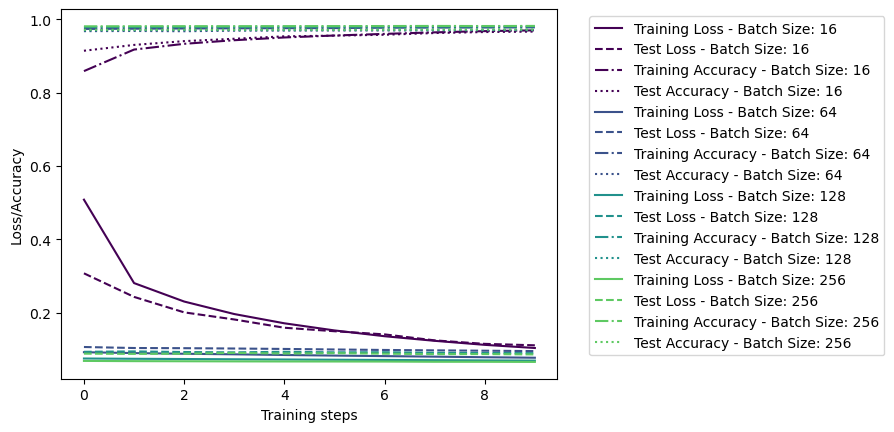

In [25]:
# BATCH SIZE

import tensorflow as tf
import numpy as np


EPOCHS = 10
model = MLPModel(layer_sizes=[256, 256], output_size=10)
cce = tf.keras.losses.CategoricalCrossentropy()
batch_list = [16, 64, 128, 256]
lr = 0.003

results = []  # To store the results for each learning rate


for bl in batch_list:
    train_dataset = data_pipeline(train_ds, bl)
    test_dataset = data_pipeline(test_ds, bl)
    sgd_optimizer = tf.keras.optimizers.legacy.SGD(learning_rate=lr)

    # Assuming train_dataset and test_dataset are your TensorFlow datasets
    train_losses, test_losses, train_accuracies, test_accuracies = train_model(
        EPOCHS, model, train_dataset, test_dataset, cce, lr, sgd_optimizer)

    # Save results for later visualization
    results.append({
        'learn ing_rate': lr,
        'train_losses': np.array(train_losses),
        'test_losses': np.array(test_losses),
        'train_accuracies': np.array(train_accuracies),
        'test_accuracies': np.array(test_accuracies)
    })

# Now you can visualize the results
visualization(results, [f'Batch Size: {bl}' for bl in batch_list])


Epoch 1,
 Train Loss: 1.6673942804336548, Train Accuracy: 0.53865,
 Test Loss: 1.1516698598861694, Test Accuracy: 0.726
Epoch 2,
 Train Loss: 0.9337397217750549, Train Accuracy: 0.76865,
 Test Loss: 0.7545536756515503, Test Accuracy: 0.8147
Epoch 3,
 Train Loss: 0.6785820722579956, Train Accuracy: 0.8229166666666666,
 Test Loss: 0.5897881388664246, Test Accuracy: 0.8479
Epoch 4,
 Train Loss: 0.5650630593299866, Train Accuracy: 0.8484333333333334,
 Test Loss: 0.5156824588775635, Test Accuracy: 0.8608
Epoch 5,
 Train Loss: 0.5012274384498596, Train Accuracy: 0.8619166666666667,
 Test Loss: 0.45703038573265076, Test Accuracy: 0.871
Epoch 6,
 Train Loss: 0.46030518412590027, Train Accuracy: 0.8720666666666667,
 Test Loss: 0.4228746294975281, Test Accuracy: 0.8779
Epoch 7,
 Train Loss: 0.4316290020942688, Train Accuracy: 0.8785833333333334,
 Test Loss: 0.4045971930027008, Test Accuracy: 0.885
Epoch 8,
 Train Loss: 0.40944206714630127, Train Accuracy: 0.8836166666666667,
 Test Loss: 0.389232

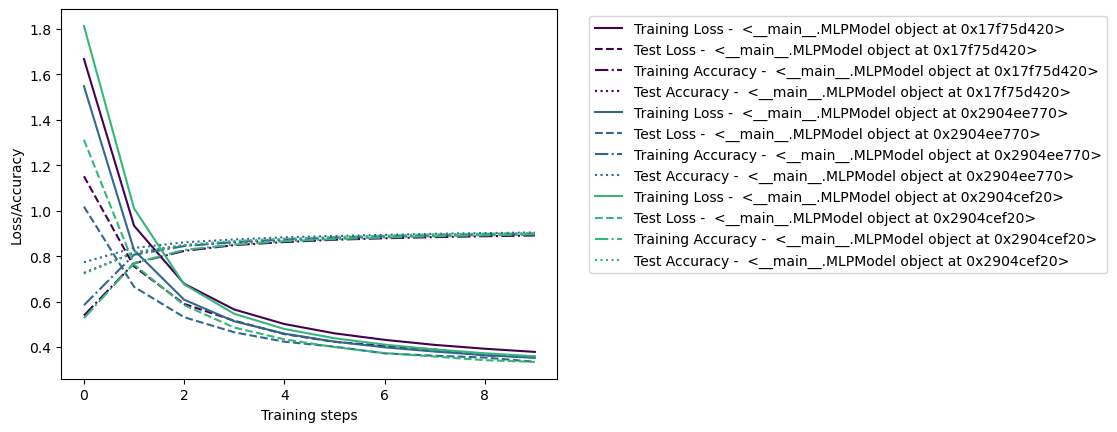

In [26]:
# Different layer sizes 

import tensorflow as tf
import numpy as np

EPOCHS = 10
model1 = MLPModel(layer_sizes=[128, 128], output_size=10)
model2 = MLPModel(layer_sizes=[256, 256], output_size=10)
model3 = MLPModel(layer_sizes=[128, 256, 512], output_size=10)

model_list = [model1, model2, model3]

cce = tf.keras.losses.CategoricalCrossentropy()
lr = 0.003

results = []  # To store the results for each learning rate

for model in model_list:
    sgd_optimizer = tf.keras.optimizers.legacy.SGD(learning_rate=lr)

    # Assuming train_dataset and test_dataset are your TensorFlow datasets
    train_losses, test_losses, train_accuracies, test_accuracies = train_model(
        EPOCHS, model, train_dataset, test_dataset, cce, lr, sgd_optimizer)

    # Save results for later visualization
    results.append({
        'learning_rate': lr,
        'train_losses': np.array(train_losses),
        'test_losses': np.array(test_losses),
        'train_accuracies': np.array(train_accuracies),
        'test_accuracies': np.array(test_accuracies)
    })

# Now you can visualize the results
visualization(results, [f' {model}' for model in model_list])
